In [1]:
# notebook last tested with abtem version 1.0.0beta13

from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
from ase.build import mx2

from abtem import *
from abtem.structures import orthogonalize_cell

current version: 1.0.0beta13


# 4D-STEM simulation of MoS$_2$

We set up an atomic structure with ASE and make sure to repeat the structure to improve the Fourier space sampling for our diffraction patterns.

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

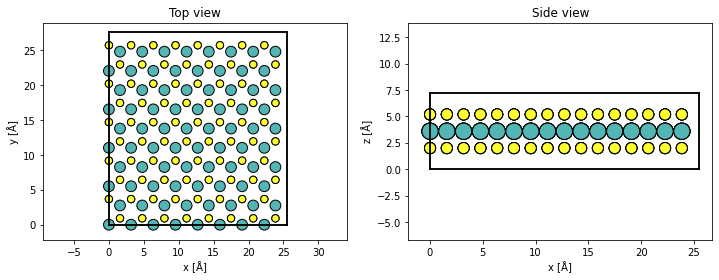

In [2]:
atoms = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(1, 1, 1), vacuum=None)

repetitions = (8, 5, 1)

atoms = orthogonalize_cell(atoms)

atoms *= repetitions

atoms.center(vacuum=2, axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [3]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([25.44, 27.53960784034515, 7.1899999999999995])


We create and calculate the electrostatic potential.

In [4]:
potential = Potential(atoms, 
                      gpts=512,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland').build(pbar=True)

In [5]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.0496875, 0.05378829656317412)


We create a probe with a semi-angle cutoff of 20 mrad.

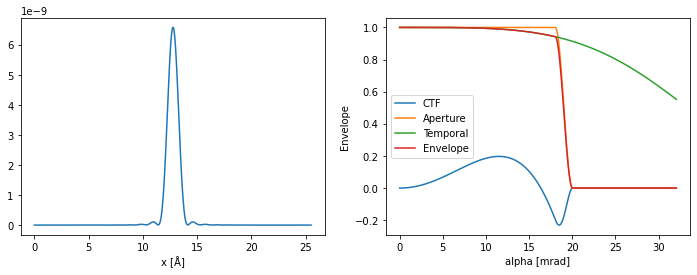

In [6]:
probe = Probe(energy=80e3, semiangle_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=20)

probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
probe.profile().show(ax=ax1);
probe.ctf.show(ax=ax2);

We create a `Pixelated` detector which will detect the diffraction patterns up to the limit set by the antialiasing aperture.

In [7]:
detector = PixelatedDetector(max_angle='limit')

We scan over one periodic unit of the potential at the nyquist frequency of the probe.

In [8]:
scan_end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

gridscan = GridScan(start=[0, 0], end=scan_end, sampling=probe.ctf.nyquist_sampling * .9)

measurement = probe.scan(gridscan, detector, potential)

The `Measurement` object returned by the scan method contains the 4D dataset. We obtain the numpy array below.

In [9]:
print(measurement, measurement.array.shape)

<abtem.measure.Measurement object at 0x0000024D14859100> (7, 12, 316, 342)


Single diffraction patterns can be obtained by indexing. The first two dimensions represent the scan dimensions.

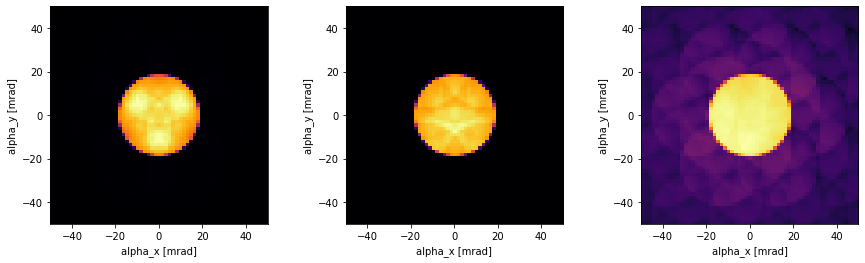

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

measurement[0, 0].show(cmap='inferno', ax=ax1)
measurement[0, 3].show(cmap='inferno', ax=ax2)
measurement[1, 1].show(cmap='inferno', ax=ax3, power=.25); # displayed on power scale

for ax in (ax1, ax2, ax3):
    ax.set_xlim([-50, 50])
    ax.set_ylim([-50, 50])

The 4D dataset can be integrated to obtain other measurements.

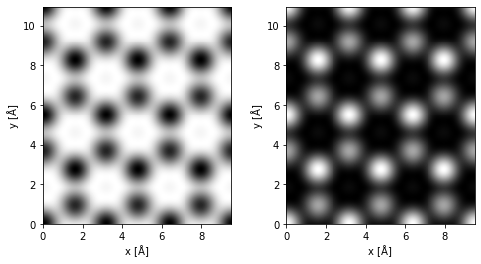

In [11]:
from abtem.detect import AnnularDetector

bright_detector = AnnularDetector(inner=0, outer=20)
maadf_detector = AnnularDetector(inner=45, outer=100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

bright_measurement = bright_detector.integrate(measurement)
bright_measurement.tile((3,2)).interpolate(.05).show(ax=ax1)

maadf_measurement = maadf_detector.integrate(measurement)
maadf_measurement.tile((3,2)).interpolate(.05).show(ax=ax2);

abTEM includes some basic analysis functions for 4D data, for example, we can calculate the center of mass. 

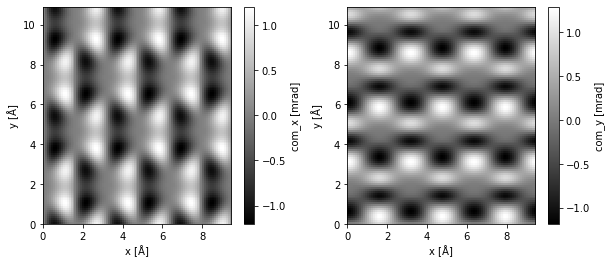

In [12]:
from abtem.measure import center_of_mass

com_x, com_y = center_of_mass(measurement)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

com_x.tile((3, 2)).interpolate(.1).show(ax=ax1, colorbar=True)
com_y.tile((3, 2)).interpolate(.1).show(ax=ax2, colorbar=True);

The integrated center-of-mass can be obtained by setting `return_icom=True`.

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x24d151cfc40>)

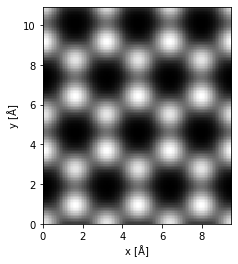

In [13]:
icom = center_of_mass(measurement, return_icom=True)

icom.interpolate(.08).tile((3,2)).show()

The position-averaged convergent beam electron diffraction (PACBED) can be obtained by averaging over the scan dimensions.

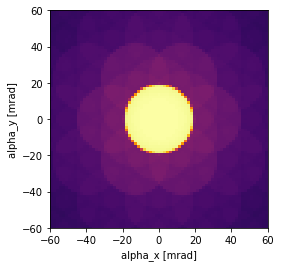

In [14]:
pacbed = measurement.mean(axis=(0, 1))

ax, _ = pacbed.show(cmap='inferno', power=.2)

ax.set_xlim([-60, 60])
ax.set_ylim([-60, 60]);